# Step 1: Finetuning for gender bias detection

In [1]:
# install required packages
!pip install -q transformers datasets evaluate scikit-learn matplotlib seaborn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback,
)
import evaluate
import torch
import torch.nn.functional as F

from IPython.display import HTML, display, clear_output
import matplotlib.animation as animation

from google.colab import drive

In [3]:
#Model to use (single model)
MODEL_KEY = "german_bert"
MODEL_NAME = "bert-base-german-cased"

# Labels mapping (keep as in original)
ID2LABEL = {0: "non-biased", 1: "biased"}
LABEL2ID = {"non-biased": 0, "biased": 1}

# Training hyperparameters (copy from original)
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
NUM_EPOCHS = 5
WEIGHT_DECAY = 0.01

# File path on Google Drive (change if needed)
CSV_PATH_IN_DRIVE = "/content/wortschatz_leipzig_extended.csv"

# Output directories
OUTPUT_DIR = f"./results_{MODEL_KEY}"
FINETUNED_DIR = f"./{MODEL_KEY}_finetuned"

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Read CSV into pandas
df = pd.read_csv(CSV_PATH_IN_DRIVE)

# Convert to HuggingFace Dataset and rename "text" -> "sentence" if necessary
if "text" in df.columns and "sentence" not in df.columns:
    df = df.rename(columns={"text": "sentence"})
elif "sentence" not in df.columns:
    raise ValueError("CSV must contain a 'sentence' or 'text' column with the text to classify.")

dataset = Dataset.from_pandas(df)

# Split into train/validation/test (same proportions as original code)
train_test = dataset.train_test_split(test_size=0.2, seed=42)
test_valid = train_test['test'].train_test_split(test_size=0.5, seed=42)

dataset_dict = {
    'train': train_test['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
}

Mounted at /content/drive


In [5]:
# Metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Callback to record per-epoch eval metrics
class EpochMetricsRecorder(TrainerCallback):

    def __init__(self):
        self.epochs = []
        self.metrics_per_epoch = []  # list of dicts with keys accuracy, precision, recall, f1

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # trainer.state.epoch contains current epoch number (float), metrics contains eval_* metrics
        if metrics is None:
            return
        # Extract epoch (convert to int if whole number)
        epoch = getattr(state, "epoch", None)
        if epoch is None:
            # fallback to length of recorded epochs + 1
            epoch = len(self.epochs) + 1
        # Metric keys may be like 'eval_accuracy'; strip "eval_" if present
        cleaned = {}
        for k, v in metrics.items():
            if k.startswith("eval_"):
                cleaned[k.replace("eval_", "")] = v
            elif k in ("accuracy", "precision", "recall", "f1"):
                cleaned[k] = v
        # Store only the 4 metrics we care about (if present)
        entry = {m: cleaned.get(m, None) for m in ["accuracy", "precision", "recall", "f1"]}
        self.epochs.append(epoch)
        self.metrics_per_epoch.append(entry)

# Instantiate recorder
recorder = EpochMetricsRecorder()

In [7]:
# Train & Evaluate (single model)

def train_and_evaluate_single_model(model_name, dataset_dict, model_key):

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize dataset (padding/truncation to max length)
    def tokenize(batch):
        return tokenizer(batch["sentence"], padding="max_length", truncation=True)

    tokenized_datasets = {}
    for split, ds in dataset_dict.items():
        tokenized = ds.map(tokenize, batched=True)
        # rename column "label" -> "labels" if necessary (HuggingFace expects "labels")
        if "label" in tokenized.column_names and "labels" not in tokenized.column_names:
            tokenized = tokenized.rename_column("label", "labels")
        tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
        tokenized_datasets[split] = tokenized

    # Load model (classification head with 2 labels and label mapping)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        id2label=ID2LABEL,
        label2id=LABEL2ID
    )

    # Training arguments
    args = TrainingArguments(
        output_dir=f"{OUTPUT_DIR}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=WEIGHT_DECAY,
        logging_dir="./logs",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        # reduce verbosity slightly
        logging_strategy="epoch",
        save_total_limit=3,
        seed=42
    )

    # Create Trainer with our recorder callback
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[recorder]  # register callback to record epoch metrics
    )

    # Train model
    trainer.train()

    # Evaluate on test set (final)
    results = trainer.evaluate(tokenized_datasets["test"])
    print(f"\n📊 Final test results for {model_key}:")
    for k, v in results.items():
        print(f"  {k}: {v}")

    # Save model and tokenizer
    model.save_pretrained(FINETUNED_DIR)
    tokenizer.save_pretrained(FINETUNED_DIR)
    print(f"\nModel and tokenizer saved to: {FINETUNED_DIR}")

    return results, trainer, tokenizer, model, recorder

# Run training for single model
results, trainer_obj, tokenizer_obj, model_obj, recorder_obj = train_and_evaluate_single_model(MODEL_NAME, dataset_dict, MODEL_KEY)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1308842757.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shkliarenko-uiux (shkliarenko-uiux-university-of-regensburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.513300,0.276971,0.850000,0.855833,0.850000,0.848612
2,0.221700,0.254123,0.910000,0.917583,0.910000,0.909167
3,0.109700,0.254788,0.910000,0.911169,0.910000,0.909755
4,0.058500,0.285377,0.930000,0.931315,0.930000,0.929809
5,0.035600,0.307739,0.920000,0.922350,0.920000,0.919677



📊 Final test results for german_bert:
  eval_loss: 0.33094796538352966
  eval_accuracy: 0.89
  eval_precision: 0.8903331995182657
  eval_recall: 0.89
  eval_f1: 0.8900773791578735
  eval_runtime: 0.6994
  eval_samples_per_second: 142.979
  eval_steps_per_second: 10.009
  epoch: 5.0

Model and tokenizer saved to: ./german_bert_finetuned


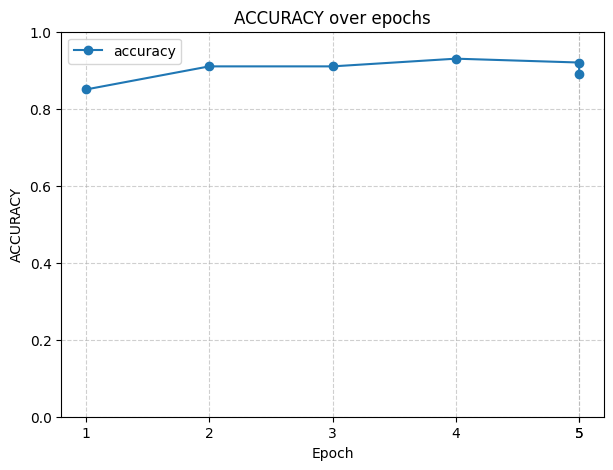

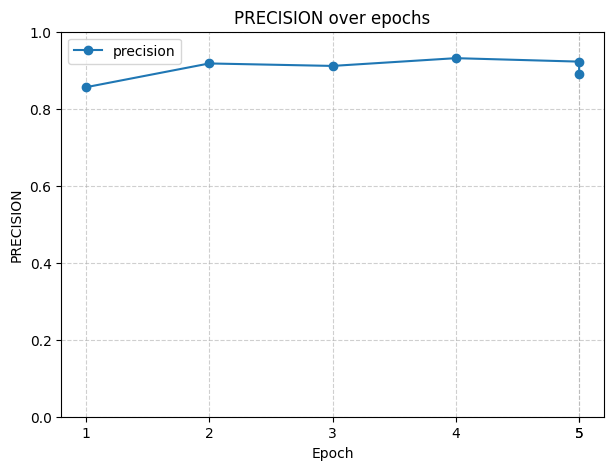

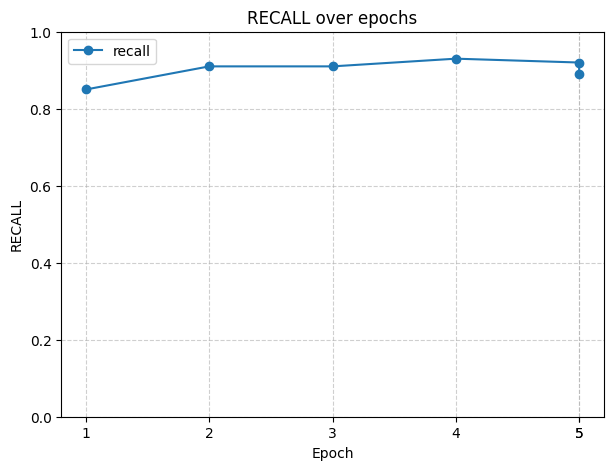

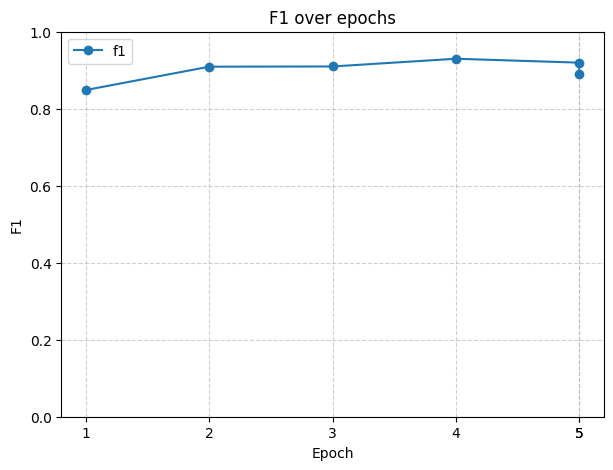

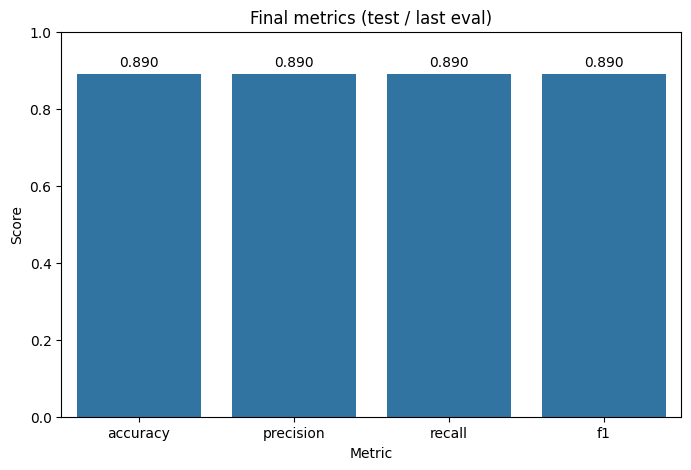

In [12]:
# Create dynamic animation of metrics per epoch
# ---------------------------
# ---------------------------
# Static plots: metrics over epochs
# ---------------------------
def plot_metrics_over_epochs(recorder):
    """
    Plot static line charts for each metric across epochs.
    """
    epochs = recorder.epochs
    metrics_list = recorder.metrics_per_epoch

    if len(epochs) == 0:
        print("No epoch metrics recorded. Make sure eval_strategy='epoch' and recorder callback ran.")
        return

    # Prepare dict of lists
    metric_names = ["accuracy", "precision", "recall", "f1"]
    values_dict = {m: [entry[m] for entry in metrics_list] for m in metric_names}

    for m in metric_names:
        plt.figure(figsize=(7, 5))
        plt.plot(epochs, values_dict[m], marker="o", label=m)
        plt.title(f"{m.upper()} over epochs")
        plt.xlabel("Epoch")
        plt.ylabel(m.upper())
        plt.ylim(0, 1)
        plt.xticks(epochs)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend()
        plt.show()

# Draw per-epoch metric charts
plot_metrics_over_epochs(recorder_obj)

# ---------------------------
# Final bar chart with metrics
# ---------------------------
def plot_final_metrics(results_dict, recorder):
    """
    Plot a final grouped bar chart with the last-recorded metrics.
    results_dict: trainer.evaluate(...) result dict (might include eval_ prefixes)
    recorder: EpochMetricsRecorder (we use last epoch metrics if available)
    """
    if len(recorder.metrics_per_epoch) > 0:
        final_metrics = recorder.metrics_per_epoch[-1]
    else:
        final_metrics = {}
        for k, v in results_dict.items():
            if k.startswith("eval_"):
                final_metrics[k.replace("eval_", "")] = v
        final_metrics = {m: final_metrics.get(m, None) for m in ["accuracy", "precision", "recall", "f1"]}

    metrics = ["accuracy", "precision", "recall", "f1"]
    values = [final_metrics.get(m, 0.0) for m in metrics]

    plt.figure(figsize=(8,5))
    sns.barplot(x=metrics, y=values)
    plt.ylim(0, 1)
    plt.title("Final metrics (test / last eval)")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
    plt.show()

# Final metrics chart
plot_final_metrics(results, recorder_obj)



In [50]:
# Example test sentences (same as original)
test_sentence("Die Krankenschwester kümmerte sich um die Patienten.", model_obj, tokenizer_obj)
test_sentence("Die Schüler diskutierten ihre Forschungsergebnisse im Seminar.", model_obj, tokenizer_obj)
test_sentence("Die Studierende diskutierten ihre Forschungsergebnisse im Seminar.", model_obj, tokenizer_obj)

Sentence: Die Krankenschwester kümmerte sich um die Patienten.
Prediction: biased (confidence: 0.999)
Sentence: Die Schüler diskutierten ihre Forschungsergebnisse im Seminar.
Prediction: biased (confidence: 0.999)
Sentence: Die Studierende diskutierten ihre Forschungsergebnisse im Seminar.
Prediction: non-biased (confidence: 0.996)


('non-biased', np.float32(0.99570906))

In [13]:
drive_dest = "/content/drive/MyDrive/german_bert_finetuned"
!cp -r {FINETUNED_DIR} {drive_dest}
print(f"Copied fine-tuned model to: {drive_dest}")

Copied fine-tuned model to: /content/drive/MyDrive/german_bert_finetuned


# Step 2: Paraphrasing

In [14]:
!pip install -q transformers datasets evaluate sacrebleu matplotlib seaborn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.1 MB/s eta 0:00:00


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from datasets import Dataset
from transformers import (
    MBartForConditionalGeneration,
    MBart50TokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
import evaluate

from google.colab import drive

In [16]:
# Load dataset
# ==========================
# CSV must contain columns: "input_text", "target_text"
df = pd.read_csv("/content/wortschatz_leipzig_extended - intext_outtext.csv")
dataset = Dataset.from_pandas(df)

# Train/validation split
dataset = dataset.train_test_split(test_size=0.1, seed=42)

In [17]:
# ==========================
# Load model & tokenizer
# ==========================
model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Set source and target language to German
tokenizer.src_lang = "de_DE"
tokenizer.tgt_lang = "de_DE"

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [18]:
#Preprocessing
# ==========================
def preprocess(examples):
    inputs = examples["input_text"]
    targets = examples["target_text"]

    model_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True)
    labels = tokenizer(targets, max_length=128, padding="max_length", truncation=True).input_ids

    # Replace pad token id's with -100 so they are ignored in loss
    labels = [[(id if id != tokenizer.pad_token_id else -100) for id in label] for label in labels]
    model_inputs["labels"] = labels
    return model_inputs

tokenized = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

In [19]:
# Define metrics
# ==========================
sacrebleu = evaluate.load("sacrebleu")

def compute_metrics(eval_pred):
    """
    Compute SacreBLEU score for generated sequences.
    """
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 with pad token id before decoding labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # SacreBLEU expects a list of hypotheses and a list of list of references
    result = sacrebleu.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])

    return {"bleu": result["score"]}

In [21]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [26]:
# Training setup
# ==========================
training_args = Seq2SeqTrainingArguments(
    output_dir="./biased2neutral_de",
    eval_strategy="epoch",   # <- у Seq2SeqTrainingArguments ключ называется evaluation_strategy
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=20,
    report_to="none",
    predict_with_generate=True,  # теперь допустимо
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="bleu"
)

# Data collator for seq2seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# ==========================
# Trainer
# ==========================
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

/tmp/ipython-input-1984302237.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Bleu
1,0.346200,0.460266,66.686230
2,0.183200,0.506827,66.426315
3,0.120500,0.450549,69.097196
4,0.058900,0.505693,67.360935
5,0.021100,0.507977,69.010827


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=570, training_loss=0.19120844461415942, metrics={'train_runtime': 227.0424, 'train_samples_per_second': 9.976, 'train_steps_per_second': 2.511, 'total_flos': 613568615546880.0, 'train_loss': 0.19120844461415942, 'epoch': 5.0})

In [27]:
# Save model to Google Drive
# ==========================
drive.mount('/content/drive')
drive_model_path = "/content/drive/MyDrive/biased2neutral_mbart_final"

model.save_pretrained(drive_model_path)
tokenizer.save_pretrained(drive_model_path)
print("Model and tokenizer saved to:", drive_model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer saved to: /content/drive/MyDrive/biased2neutral_mbart_final


Saved training metrics to training_metrics.csv
Columns available: Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_bleu', 'eval_runtime', 'eval_samples_per_second',
       'eval_steps_per_second', 'train_runtime', 'train_samples_per_second',
       'train_steps_per_second', 'total_flos', 'train_loss'],
      dtype='object')


/tmp/ipython-input-3266839741.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_epochs = df_epochs.fillna(method="ffill")


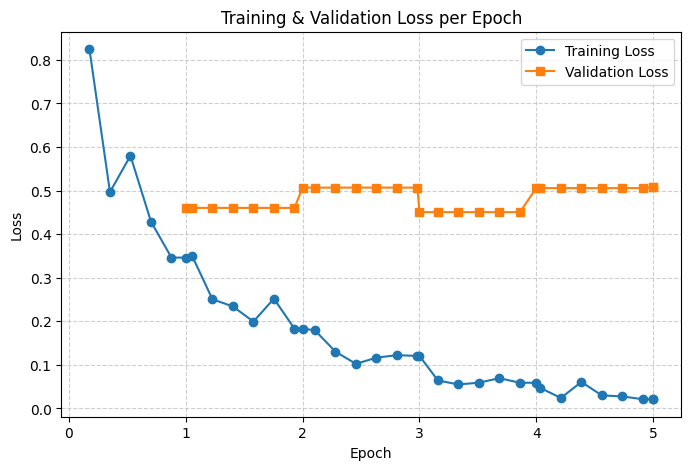

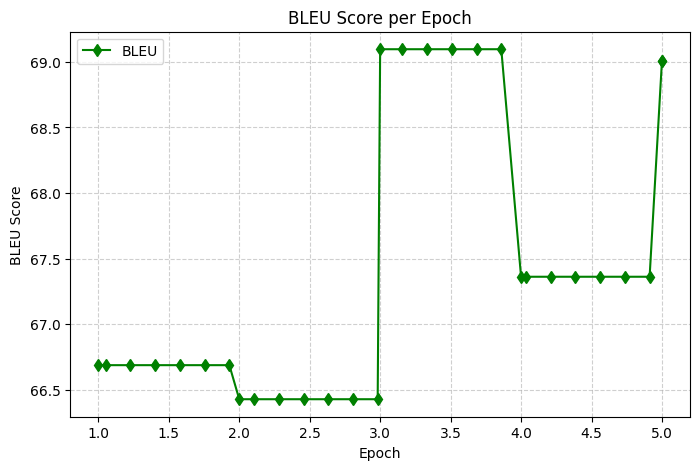

In [29]:
# Save training metrics
# ==========================
df_metrics = pd.DataFrame(trainer.state.log_history)
df_metrics.to_csv("training_metrics.csv", index=False)
print("Saved training metrics to training_metrics.csv")
print("Columns available:", df_metrics.columns)

# ==========================
# Visualization (by epoch)
# ==========================
# Convert logs into DataFrame
df_metrics = pd.DataFrame(trainer.state.log_history)

# Keep only rows that have "epoch"
df_epochs = df_metrics.dropna(subset=["epoch"])

# Fill missing values
df_epochs = df_epochs.fillna(method="ffill")

# Plot Training vs Validation Loss
plt.figure(figsize=(8,5))
if "loss" in df_epochs.columns:
    plt.plot(df_epochs["epoch"], df_epochs["loss"], marker="o", label="Training Loss")
if "eval_loss" in df_epochs.columns:
    plt.plot(df_epochs["epoch"], df_epochs["eval_loss"], marker="s", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot BLEU score per epoch
if "eval_bleu" in df_epochs.columns:
    plt.figure(figsize=(8,5))
    plt.plot(df_epochs["epoch"], df_epochs["eval_bleu"], marker="d", color="green", label="BLEU")
    plt.xlabel("Epoch")
    plt.ylabel("BLEU Score")
    plt.title("BLEU Score per Epoch")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [48]:
# ==========================
# Quick inference test (with device handling)
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

text = "Die Schüler können selbst entscheiden, was sie tun möchten."

# Tokenize and send input to the same device
inputs = tokenizer(text, return_tensors="pt").to(device)

# Generate
output_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4)

print("Original:", text)
print("Rewritten:", tokenizer.decode(output_ids[0], skip_special_tokens=True))

Original: Die Schüler können selbst entscheiden, was sie tun möchten.
Rewritten: Die Schüler*innen können selbst entscheiden, was sie tun möchten.


# Step 3: GleichText Implmentation

In [33]:
import torch
import torch.nn.functional as F
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    MBartForConditionalGeneration, MBart50TokenizerFast
)

In [38]:
# Before running this block, make sure you have set the correct paths to your trained models on Google Drive
# in the variables `bert_path` and `mbart_path` above.

bert_path = "/content/drive/MyDrive/german_bert_finetuned"  #<-- insert your BERT finetuned model path here
bert_tokenizer = AutoTokenizer.from_pretrained(bert_path)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_path)  #<-- insert your mBART finetuned model path here

mbart_path = "/content/drive/MyDrive/biased2neutral_mbart_final"
mbart_tokenizer = MBart50TokenizerFast.from_pretrained(mbart_path)
mbart_model = MBartForConditionalGeneration.from_pretrained(mbart_path)

mbart_tokenizer.src_lang = "de_DE"
mbart_tokenizer.tgt_lang = "de_DE"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)
mbart_model = mbart_model.to(device)

In [36]:
def check_and_rewrite(sentence: str):
    """
    1. Check sentence for gender bias with BERT classifier.
    2. If biased → rewrite with mBART paraphraser.
    3. Return result as string.
    """

    # --- Step 1: Classification ---
    inputs = bert_tokenizer(sentence, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1).cpu().numpy()[0]

    pred_label = int(probs.argmax())
    confidence = probs.max()

    # --- Step 2: Decision ---
    if pred_label == 0:  # non-biased
        return f"✅ Im Text wurden keine Anzeichen für Gender Bias gefunden. (Sicherheit: {confidence:.2f})"
    else:
        # --- Step 3: Rewriting ---
        inputs_mbart = mbart_tokenizer(sentence, return_tensors="pt").to(device)
        with torch.no_grad():
            output_ids = mbart_model.generate(
                inputs_mbart["input_ids"],
                max_length=128,
                num_beams=4
            )
        rewritten = mbart_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return (
            f"⚠️ Leider scheint der Text Gender Bias zu enthalten "
            f"(Sicherheit: {confidence:.2f}).\n"
            f"👉 Vorschlag für eine umgeschriebene Version:\n\n{rewritten}"
        )

# Step 4: GleichText-Test

In [47]:
print(check_and_rewrite("Die Krankenschwester kümmerte sich um die Patienten."))
print("------------------------------------------------------")
print(check_and_rewrite("Den Besuchern hat die neue Ausstellung sehr gut gefallen."))
print("------------------------------------------------------")
print(check_and_rewrite("Die Studierende diskutierten ihre Forschungsergebnisse im Seminar."))

⚠️ Leider scheint der Text Gender Bias zu enthalten (Sicherheit: 1.00).
👉 Vorschlag für eine umgeschriebene Version:

Die Krankenpflege kümmerte sich um die Patienten.
------------------------------------------------------
⚠️ Leider scheint der Text Gender Bias zu enthalten (Sicherheit: 1.00).
👉 Vorschlag für eine umgeschriebene Version:

Den Besucher*innen hat die neue Ausstellung sehr gut gefallen.
------------------------------------------------------
✅ Im Text wurden keine Anzeichen für Gender Bias gefunden. (Sicherheit: 1.00)
